# Welcome to the live demo of 'Pandas Like Logs'

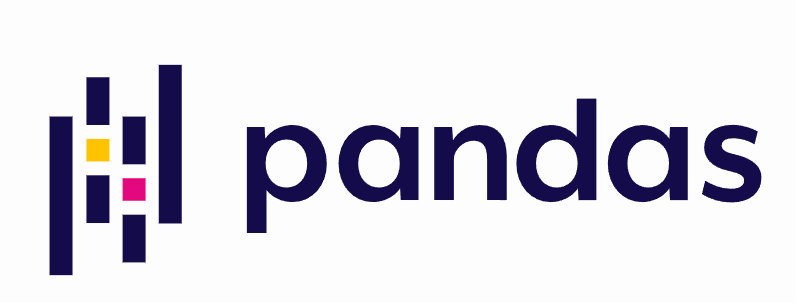

Image pulled from https://pypi.org/project/pandas/

### Today, we'll see some uses for python pandas as we sift through some logs. 
<br>
<li>We'll start by looking at some network logs. For this, we'll use bro logs collected from aktaion2 github.</li>
<li>Then, we'll move on to searching through a group of logs for a set of Indicators of Compromise. Pandas makes this easy. We'll even add a labeling column for any hits we find.</li>
<li>Last, we'll talk about some host based logs and look for anomilies that we may find there.</li>

# Part 1 - Network logs

There may be times when you have to export some logs (or have them given to you) and you'll have to sift through them for malicious or at least suspicious things. This is an example of that. 

## import pandas and some other things

In [ ]:
import pandas as pd
import datetime
import re
import logparser as lp 

## Initialize the variable you'll use to hold the text from the files (we will regex these files later to parse them)

In [ ]:
x= ""

## Read the file (i'm doing one at a time, there are defintely better ways to do it)

In [ ]:
with open('/Users/sacamero/Documents/Pandas class/bro_http01.log') as f:
    x = f.readlines()

In [ ]:
x

## Regex your fields to parse the logs

In [ ]:
bro_http = re.compile('^.*(?P<time>\d{10})\.\d{6}\s\w+\s(?P<src_ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\s(?P<src_port>\d+?)\s(?P<dst_ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\s(?P<dst_port>\d+?)\s\d+\s(?P<method>[A-Z]{3,4})\s(?P<domain>[\w\.\-]+)\s(?P<uri>.+?)\s(?P<referer>.+?)\s(?P<user_agent>.+?)\s\d+\s\d+\s(?P<response_code>\d{3}|-)\s(?P<response_message>.+?)\s')

In [ ]:
df = lp.parse_messages(x,bro_http)

In [ ]:
with open('/Users/sacamero/Documents/Pandas class/bro_http02.log') as f:
    x = f.readlines()

In [ ]:
df2 = lp.parse_messages(x,bro_http)

In [ ]:
df = df.append(df2) #let's append the two data frame above to each other

In [ ]:
df = df.reset_index(drop=True)

## We have parsed the logs and added them to a dataframe! We are ready to get started

## Let's see what a dataframe even looks like

In [ ]:
df.head()

## This looks like a .csv file or excel spreadsheet

In [ ]:
df.shape #How many rows, columns are in this dataframe

In [ ]:
df.columns #what columns do we have

## Pandas allows you to store different data types in the columns. This time, all of our data is stored as an object. (this will become important in a bit)

In [ ]:
df.dtypes

## Sort by time

In [ ]:
df['time'] #let's see what our time column looks like

## Looks like we had some NaN values (this just means it is empty for the most part). These could be things like headers, footers that were in the file when we imported or mis formatted logs. Regardless, we'll go ahead and drop any rows that have NaN in the time column.

In [ ]:
df = df[df['time'].notna()] #notna() is a built in function with pandas that can handle that

In [ ]:
df.head()

## Since zeek logs give us epoch time, let's convert to human readable using this function (we will apply the function later)

In [ ]:
def getstandardtime(i):
    c = datetime.datetime.fromtimestamp(int(i)).strftime('%Y-%m-%d %H:%M:%S')
    return c

## Insert a new row (technically not needed but showing you how to just because)

In [ ]:
df.insert(2,'readable_event_time',"")

In [ ]:
df.columns

## Apply a user defined function

In [ ]:
df['readable_event_time'] = df['time'].apply(getstandardtime) #apply the user-defined function to convert epoch time to regular time

In [ ]:
df['readable_event_time'] #let's take a look

In [ ]:
df['readable_event_time'] = pd.to_datetime(df['readable_event_time']) #make it a datetime object

In [ ]:
df['readable_event_time'].head

In [ ]:
df = df.sort_values(by='readable_event_time')

In [ ]:
df.head(20)

In [ ]:
df.groupby('domain')['src_ip'].value_counts()

In [ ]:
df[df.domain.str.contains('\.com$', regex=True, case=False, na=False)==False].domain

In [ ]:
for i in df.dst_ip.unique():
    print(i)

In [ ]:
def abuse_ip_db(a):
    import requests
    import json
    url = 'https://api.abuseipdb.com/api/v2/check'
    querystring = {
        'ipAddress': a,
        'maxAgeInDays': '90'
    }
    headers = {
        'Accept': 'application/json',
        'Key': '[get your API key]'
    }
    response = requests.request(method='GET', url=url, headers=headers, params=querystring)
    decodedResponse = json.loads(response.text)
    num_times_reported = decodedResponse['data']['totalReports']
    return num_times_reported

In [ ]:
df['number_of_times_reported'] = df['dst_ip'].apply(abuse_ip_db)

In [ ]:
df[['dst_ip', 'number_of_times_reported']]

In [ ]:
df[df['number_of_times_reported']>0].domain

## Ok I have one lead

In [ ]:
df.iloc[134]

In [ ]:
print(df.iloc[134]['domain'] + df.iloc[134]['uri'] + '\n\n' + df.iloc[134]['raw_log'])

In [ ]:
df[df['uri'].str.contains('(\.exe|\.tar|\.cmd|\.ps1)')].uri #extra

## hxxps://otx.alienvault.com/indicator/domain/iamthewinnerhere.com

## You can do plenty of other things as well with this using pandas (EXTRA)

In [ ]:
for i in df.domain.unique():
    print(i)
    print(df[df['domain']==i].response_code.unique())
    #df3 = df[df['domain'].notna()]
    #print(i + ' : ' + df3[df3['domain']==i].response_code.values)

In [ ]:
df.groupby('method')['domain'].value_counts()

In [ ]:
df.dst_ip.describe()

In [ ]:
df[df['dst_ip']=='199.19.251.164'].count()

# Part 2 - Search using a definite list through logs

There may be a time when you are handed a set of logs or events and you must sift through them with a known set of indicators. You may even want to label the rows that do have a hit with a threat name based on the IOC set you use. 

## First we will import a set of logs. This is especially useful when you have csv, excel, json files. 

In [ ]:
df_ioc = pd.read_csv('/Users/sacamero/Documents/Pandas class/pan_http.csv') #these are Palo Alto style logs

In [ ]:
df_ioc.head(3) #Let's take a peek

In [ ]:
df_ioc.columns #See what columns we have

In [ ]:
df_ioc['Destination_address'].unique() #See what column stores out destinations

In [ ]:
df_ioc['time'] = pd.to_datetime(df_ioc['Time_Logged']) #convert the time to datetime

In [ ]:
df_ioc['time'].head() #take a peek

## Now we will gather the IOCs we want. For this example, i used OTX (Alien Vault) but the idea is to just gather them into an array. Since I am importing from a text file, I have to manipulate them a bit


IOC's gathered from: https://otx.alienvault.com/pulse/6172b098ff98e65aff9e496c (Trickbot)

In [ ]:
x = []
with open('/Users/sacamero/Documents/Pandas class/trickbot_iocs.txt') as f:
    for line in f:
        x.append(line)

In [ ]:
x #take a look

In [ ]:
iocs = [i.strip() for i in x] #get rid of those newline characters

In [ ]:
iocs #Notice how we stripped the \n

## Now let's actually run the query to look at the Desintation address column for any occurences of the items in our array

In [ ]:
df_hits = df_ioc.query("Destination_address in @iocs")

## Always a good idea to sort by time just for good measure

In [ ]:
df_hits = df_hits.sort_values(by='Time_Logged') #then we will sort the df by time

In [ ]:
df_hits.groupby('Source_address')['Destination_address'].value_counts() #having some fun looking at the different values

In [ ]:
df_hits.groupby(['Source_address', 'Action'])['Destination_address'].value_counts() #having some fun looking at the different values

In [ ]:
df_hits['time']

In [ ]:
df_hits = df_hits.sort_values(by='time') #now sort just for good measure

In [ ]:
df_hits.columns

In [ ]:
df_hits.groupby(['time', 'Source_address'])['Destination_address'].value_counts()

In [ ]:
df_hits.groupby(['Source_address'])['Destination_address'].count().plot(kind='bar', rot=45)

## Last, we will put a bit of a spin on this. We will be searching through the logs and, if a match is found on an IOC, put a threat name label in a seperate column

In [ ]:
#Qakbot
#https://otx.alienvault.com/pulse/6176f6bc98ef0c3e11a12577

#gather the IOCs into an array like before
    
qak = ['96.246.158.154','87.242.20.233','87.109.246.232','85.54.179.210','189.146.41.71','187.75.66.160','176.78.108.235']

In [ ]:
#Gandcrab
#https://otx.alienvault.com/pulse/6173bc47718ff040c23d6ab9

#gather the IOCs into an array like before
    
gan = ['13.107.42.12','160.72.43.240','185.7.214.212','211.231.108.46','45.9.20.178','51.81.57.58','74.208.5.20']

In [ ]:
df_ioc.query('Destination_address in @qak') # we can see that we do, in fact have hits for Qakbot

In [ ]:
df_ioc.query('Destination_address in @gan') # we can see that we do, in fact have hits for Gandcrab

In [ ]:
for i in qak:
    df_ioc.loc[df_ioc['Destination_address'].str.contains(i), 'threat_name'] = 'Qakbot'

In [ ]:
for i in gan:
    df_ioc.loc[df_ioc['Destination_address'].str.contains(i), 'threat_name'] = 'Gandcrab'

In [ ]:
df_ioc[['time','Source_address', 'Destination_address', 'threat_name']]

In [ ]:
df_ioc['threat_name'].value_counts()

In [ ]:
df_ioc.groupby(['threat_name','Source_address'])['Destination_address'].value_counts()

In [ ]:
df_ioc[['time', 'Source_address', 'Destination_address', 'threat_name']]

# That's it folks

In [ ]:
# If you are curious as to what log parser is, this is the function 

import re
import pandas as pd

def parse_message(message,*args):

    parsed = {}

    parsed['raw_log'] = message
    for pattern in args:
        m = pattern.search(message)
        if m:
            parsed.update(m.groupdict())
        else:
            continue

    return parsed

def parse_messages(messages,*args):
    return pd.DataFrame([parse_message(message,*args) for message in messages])

In [ ]:
## There are many other ways to read files into a dataframe if you have logs that are already parsed. Here is an example of doing it with json parsed data


df_json_import = pd.read_json('/Users/sacamero/Documents/Pandas class/empire_shell_net_local_users_2020-09-21192606.json', lines=True)

#gathered from https://github.com/OTRF/Security-Datasets/tree/master/datasets/atomic/windows/*


In [ ]:
df_json_import